# Transfer Learning Template

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

    
import os, json, sys, time, random
import numpy as np
import torch
from torch.optim import Adam
from  easydict import EasyDict
import matplotlib.pyplot as plt

from steves_models.steves_ptn import Steves_Prototypical_Network

from steves_utils.lazy_iterable_wrapper import Lazy_Iterable_Wrapper
from steves_utils.iterable_aggregator import Iterable_Aggregator
from steves_utils.ptn_train_eval_test_jig import  PTN_Train_Eval_Test_Jig
from steves_utils.torch_sequential_builder import build_sequential
from steves_utils.torch_utils import get_dataset_metrics, ptn_confusion_by_domain_over_dataloader
from steves_utils.utils_v2 import (per_domain_accuracy_from_confusion, get_datasets_base_path)
from steves_utils.PTN.utils import independent_accuracy_assesment

from torch.utils.data import DataLoader

from steves_utils.stratified_dataset.episodic_accessor import Episodic_Accessor_Factory

from steves_utils.ptn_do_report import (
    get_loss_curve,
    get_results_table,
    get_parameters_table,
    get_domain_accuracies,
)

from steves_utils.transforms import get_chained_transform

# Allowed Parameters
These are allowed parameters, not defaults
Each of these values need to be present in the injected parameters (the notebook will raise an exception if they are not present)

Papermill uses the cell tag "parameters" to inject the real parameters below this cell.
Enable tags to see what I mean

In [2]:
required_parameters = {
    "experiment_name",
    "lr",
    "device",
    "seed",
    "dataset_seed",
    "n_shot",
    "n_query",
    "n_way",
    "train_k_factor",
    "val_k_factor",
    "test_k_factor",
    "n_epoch",
    "patience",
    "criteria_for_best",
    "x_net",
    "datasets",
    "torch_default_dtype",
    "NUM_LOGS_PER_EPOCH",
    "BEST_MODEL_PATH",
    "x_shape",
}

In [3]:
from steves_utils.CORES.utils import (
    ALL_NODES,
    ALL_NODES_MINIMUM_1000_EXAMPLES,
    ALL_DAYS
)

from steves_utils.ORACLE.utils_v2 import (
    ALL_DISTANCES_FEET_NARROWED,
    ALL_RUNS,
    ALL_SERIAL_NUMBERS,
)

standalone_parameters = {}
standalone_parameters["experiment_name"] = "STANDALONE PTN"
standalone_parameters["lr"] = 0.001
standalone_parameters["device"] = "cuda"

standalone_parameters["seed"] = 1337
standalone_parameters["dataset_seed"] = 1337

standalone_parameters["n_way"] = 8
standalone_parameters["n_shot"] = 3
standalone_parameters["n_query"]  = 2
standalone_parameters["train_k_factor"] = 1
standalone_parameters["val_k_factor"] = 2
standalone_parameters["test_k_factor"] = 2


standalone_parameters["n_epoch"] = 50

standalone_parameters["patience"] = 10
standalone_parameters["criteria_for_best"] = "source_loss"

standalone_parameters["datasets"] = [
    {
        "labels": ALL_SERIAL_NUMBERS,
        "domains": ALL_DISTANCES_FEET_NARROWED,
        "num_examples_per_domain_per_label": 100,
        "pickle_path": os.path.join(get_datasets_base_path(), "oracle.Run1_framed_2000Examples_stratified_ds.2022A.pkl"),
        "source_or_target_dataset": "source",
        "x_transforms": ["unit_mag", "minus_two"],
        "episode_transforms": [],
        "domain_prefix": "ORACLE_"
    },
    {
        "labels": ALL_NODES,
        "domains": ALL_DAYS,
        "num_examples_per_domain_per_label": 100,
        "pickle_path": os.path.join(get_datasets_base_path(), "cores.stratified_ds.2022A.pkl"),
        "source_or_target_dataset": "target",
        "x_transforms": ["unit_power", "times_zero"],
        "episode_transforms": [],
        "domain_prefix": "CORES_"
    }   
]

standalone_parameters["torch_default_dtype"] = "torch.float32" 



standalone_parameters["x_net"] =     [
    {"class": "nnReshape", "kargs": {"shape":[-1, 1, 2, 256]}},
    {"class": "Conv2d", "kargs": { "in_channels":1, "out_channels":256, "kernel_size":(1,7), "bias":False, "padding":(0,3), },},
    {"class": "ReLU", "kargs": {"inplace": True}},
    {"class": "BatchNorm2d", "kargs": {"num_features":256}},

    {"class": "Conv2d", "kargs": { "in_channels":256, "out_channels":80, "kernel_size":(2,7), "bias":True, "padding":(0,3), },},
    {"class": "ReLU", "kargs": {"inplace": True}},
    {"class": "BatchNorm2d", "kargs": {"num_features":80}},
    {"class": "Flatten", "kargs": {}},

    {"class": "Linear", "kargs": {"in_features": 80*256, "out_features": 256}}, # 80 units per IQ pair
    {"class": "ReLU", "kargs": {"inplace": True}},
    {"class": "BatchNorm1d", "kargs": {"num_features":256}},

    {"class": "Linear", "kargs": {"in_features": 256, "out_features": 256}},
]

# Parameters relevant to results
# These parameters will basically never need to change
standalone_parameters["NUM_LOGS_PER_EPOCH"] = 10
standalone_parameters["BEST_MODEL_PATH"] = "./best_model.pth"






In [4]:
# Parameters
parameters = {
    "experiment_name": "tl_1v2:oracle.run1.framed-oracle.run2.framed",
    "device": "cuda",
    "lr": 0.0001,
    "n_shot": 3,
    "n_query": 2,
    "train_k_factor": 3,
    "val_k_factor": 2,
    "test_k_factor": 2,
    "torch_default_dtype": "torch.float32",
    "n_epoch": 50,
    "patience": 3,
    "criteria_for_best": "target_accuracy",
    "x_net": [
        {"class": "nnReshape", "kargs": {"shape": [-1, 1, 2, 256]}},
        {
            "class": "Conv2d",
            "kargs": {
                "in_channels": 1,
                "out_channels": 256,
                "kernel_size": [1, 7],
                "bias": False,
                "padding": [0, 3],
            },
        },
        {"class": "ReLU", "kargs": {"inplace": True}},
        {"class": "BatchNorm2d", "kargs": {"num_features": 256}},
        {
            "class": "Conv2d",
            "kargs": {
                "in_channels": 256,
                "out_channels": 80,
                "kernel_size": [2, 7],
                "bias": True,
                "padding": [0, 3],
            },
        },
        {"class": "ReLU", "kargs": {"inplace": True}},
        {"class": "BatchNorm2d", "kargs": {"num_features": 80}},
        {"class": "Flatten", "kargs": {}},
        {"class": "Linear", "kargs": {"in_features": 20480, "out_features": 256}},
        {"class": "ReLU", "kargs": {"inplace": True}},
        {"class": "BatchNorm1d", "kargs": {"num_features": 256}},
        {"class": "Linear", "kargs": {"in_features": 256, "out_features": 256}},
    ],
    "NUM_LOGS_PER_EPOCH": 10,
    "BEST_MODEL_PATH": "./best_model.pth",
    "n_way": 16,
    "datasets": [
        {
            "labels": [
                "3123D52",
                "3123D65",
                "3123D79",
                "3123D80",
                "3123D54",
                "3123D70",
                "3123D7B",
                "3123D89",
                "3123D58",
                "3123D76",
                "3123D7D",
                "3123EFE",
                "3123D64",
                "3123D78",
                "3123D7E",
                "3124E4A",
            ],
            "domains": [32, 38, 8, 44, 14, 50, 20, 26],
            "num_examples_per_domain_per_label": 2000,
            "pickle_path": "/root/csc500-main/datasets/oracle.Run1_framed_2000Examples_stratified_ds.2022A.pkl",
            "source_or_target_dataset": "source",
            "x_transforms": [],
            "episode_transforms": [],
            "domain_prefix": "ORACLE.run1_",
        },
        {
            "labels": [
                "3123D52",
                "3123D65",
                "3123D79",
                "3123D80",
                "3123D54",
                "3123D70",
                "3123D7B",
                "3123D89",
                "3123D58",
                "3123D76",
                "3123D7D",
                "3123EFE",
                "3123D64",
                "3123D78",
                "3123D7E",
                "3124E4A",
            ],
            "domains": [32, 38, 8, 44, 14, 50, 20, 26],
            "num_examples_per_domain_per_label": 2000,
            "pickle_path": "/root/csc500-main/datasets/oracle.Run2_framed_2000Examples_stratified_ds.2022A.pkl",
            "source_or_target_dataset": "target",
            "x_transforms": [],
            "episode_transforms": [],
            "domain_prefix": "ORACLE.run2_",
        },
    ],
    "dataset_seed": 500,
    "seed": 500,
}


In [5]:
# Set this to True if you want to run this template directly
STANDALONE = False
if STANDALONE:
    print("parameters not injected, running with standalone_parameters")
    parameters = standalone_parameters

if not 'parameters' in locals() and not 'parameters' in globals():
    raise Exception("Parameter injection failed")

#Use an easy dict for all the parameters
p = EasyDict(parameters)

if "x_shape" not in p:
    p.x_shape = [2,256] # Default to this if we dont supply x_shape


supplied_keys = set(p.keys())

if  supplied_keys != required_parameters:
    print("Parameters are incorrect")
    if len(supplied_keys - required_parameters)>0: print("Shouldn't have:", str(supplied_keys - required_parameters))
    if len(required_parameters - supplied_keys)>0: print("Need to have:", str(required_parameters - supplied_keys))
    raise RuntimeError("Parameters are incorrect")

In [6]:
###################################
# Set the RNGs and make it all deterministic
###################################
np.random.seed(p.seed)
random.seed(p.seed)
torch.manual_seed(p.seed)

torch.use_deterministic_algorithms(True) 

In [7]:
###########################################
# The stratified datasets honor this
###########################################
torch.set_default_dtype(eval(p.torch_default_dtype))

In [8]:
###################################
# Build the network(s)
# Note: It's critical to do this AFTER setting the RNG
###################################
x_net = build_sequential(p.x_net)

In [9]:
start_time_secs = time.time()

In [10]:
p.domains_source = []
p.domains_target = []


train_original_source = []
val_original_source   = []
test_original_source  = []

train_original_target = []
val_original_target   = []
test_original_target  = []

In [11]:
# global_x_transform_func = lambda x: normalize(x.to(torch.get_default_dtype()), "unit_power") # unit_power, unit_mag
# global_x_transform_func = lambda x: normalize(x, "unit_power") # unit_power, unit_mag

In [12]:
def add_dataset(
    labels,
    domains,
    pickle_path,
    x_transforms,
    episode_transforms,
    domain_prefix,
    num_examples_per_domain_per_label,
    source_or_target_dataset:str,
    iterator_seed=p.seed,
    dataset_seed=p.dataset_seed,
    n_shot=p.n_shot,
    n_way=p.n_way,
    n_query=p.n_query,
    train_val_test_k_factors=(p.train_k_factor,p.val_k_factor,p.test_k_factor),
):
   
    if x_transforms == []: x_transform = None
    else: x_transform = get_chained_transform(x_transforms)
    
    if episode_transforms == []: episode_transform = None
    else: raise Exception("episode_transforms not implemented")
    
    episode_transform = lambda tup, _prefix=domain_prefix: (_prefix + str(tup[0]), tup[1])


    eaf = Episodic_Accessor_Factory(
        labels=labels,
        domains=domains,
        num_examples_per_domain_per_label=num_examples_per_domain_per_label,
        iterator_seed=iterator_seed,
        dataset_seed=dataset_seed,
        n_shot=n_shot,
        n_way=n_way,
        n_query=n_query,
        train_val_test_k_factors=train_val_test_k_factors,
        pickle_path=pickle_path,
        x_transform_func=x_transform,
    )

    train, val, test = eaf.get_train(), eaf.get_val(), eaf.get_test()
    train = Lazy_Iterable_Wrapper(train, episode_transform)
    val = Lazy_Iterable_Wrapper(val, episode_transform)
    test = Lazy_Iterable_Wrapper(test, episode_transform)

    if source_or_target_dataset=="source":
        train_original_source.append(train)
        val_original_source.append(val)
        test_original_source.append(test)

        p.domains_source.extend(
            [domain_prefix + str(u) for u in domains]
        )
    elif source_or_target_dataset=="target":
        train_original_target.append(train)
        val_original_target.append(val)
        test_original_target.append(test)
        p.domains_target.extend(
            [domain_prefix + str(u) for u in domains]
        )
    else:
        raise Exception(f"invalid source_or_target_dataset: {source_or_target_dataset}")
    

In [13]:
for ds in p.datasets:
    add_dataset(**ds)

In [14]:
# from steves_utils.CORES.utils import (
#     ALL_NODES,
#     ALL_NODES_MINIMUM_1000_EXAMPLES,
#     ALL_DAYS
# )

# add_dataset(
#     labels=ALL_NODES,
#     domains = ALL_DAYS,
#     num_examples_per_domain_per_label=100,
#     pickle_path=os.path.join(get_datasets_base_path(), "cores.stratified_ds.2022A.pkl"),
#     source_or_target_dataset="target",
#     x_transform_func=global_x_transform_func,
#     domain_modifier=lambda u: f"cores_{u}"
# )

In [15]:
# from steves_utils.ORACLE.utils_v2 import (
#     ALL_DISTANCES_FEET,
#     ALL_RUNS,
#     ALL_SERIAL_NUMBERS,
# )


# add_dataset(
#     labels=ALL_SERIAL_NUMBERS,
#     domains = list(set(ALL_DISTANCES_FEET) - {2,62}),
#     num_examples_per_domain_per_label=100,
#     pickle_path=os.path.join(get_datasets_base_path(), "oracle.Run2_framed_2000Examples_stratified_ds.2022A.pkl"),
#     source_or_target_dataset="source",
#     x_transform_func=global_x_transform_func,
#     domain_modifier=lambda u: f"oracle1_{u}"
# )


In [16]:
# from steves_utils.ORACLE.utils_v2 import (
#     ALL_DISTANCES_FEET,
#     ALL_RUNS,
#     ALL_SERIAL_NUMBERS,
# )


# add_dataset(
#     labels=ALL_SERIAL_NUMBERS,
#     domains = list(set(ALL_DISTANCES_FEET) - {2,62,56}),
#     num_examples_per_domain_per_label=100,
#     pickle_path=os.path.join(get_datasets_base_path(), "oracle.Run2_framed_2000Examples_stratified_ds.2022A.pkl"),
#     source_or_target_dataset="source",
#     x_transform_func=global_x_transform_func,
#     domain_modifier=lambda u: f"oracle2_{u}"
# )

In [17]:
# add_dataset(
#     labels=list(range(19)),
#     domains = [0,1,2],
#     num_examples_per_domain_per_label=100,
#     pickle_path=os.path.join(get_datasets_base_path(), "metehan.stratified_ds.2022A.pkl"),
#     source_or_target_dataset="target",
#     x_transform_func=global_x_transform_func,
#     domain_modifier=lambda u: f"met_{u}"
# )

In [18]:
# # from steves_utils.wisig.utils import (
# #     ALL_NODES_MINIMUM_100_EXAMPLES,
# #     ALL_NODES_MINIMUM_500_EXAMPLES,
# #     ALL_NODES_MINIMUM_1000_EXAMPLES,
# #     ALL_DAYS
# # )

# import steves_utils.wisig.utils as wisig


# add_dataset(
#     labels=wisig.ALL_NODES_MINIMUM_100_EXAMPLES,
#     domains = wisig.ALL_DAYS,
#     num_examples_per_domain_per_label=100,
#     pickle_path=os.path.join(get_datasets_base_path(), "wisig.node3-19.stratified_ds.2022A.pkl"),
#     source_or_target_dataset="target",
#     x_transform_func=global_x_transform_func,
#     domain_modifier=lambda u: f"wisig_{u}"
# )

In [19]:
###################################
# Build the dataset
###################################
train_original_source = Iterable_Aggregator(train_original_source, p.seed)
val_original_source = Iterable_Aggregator(val_original_source, p.seed)
test_original_source = Iterable_Aggregator(test_original_source, p.seed)


train_original_target = Iterable_Aggregator(train_original_target, p.seed)
val_original_target = Iterable_Aggregator(val_original_target, p.seed)
test_original_target = Iterable_Aggregator(test_original_target, p.seed)

# For CNN We only use X and Y. And we only train on the source.
# Properly form the data using a transform lambda and Lazy_Iterable_Wrapper. Finally wrap them in a dataloader

transform_lambda = lambda ex: ex[1] # Original is (<domain>, <episode>) so we strip down to episode only

train_processed_source = Lazy_Iterable_Wrapper(train_original_source, transform_lambda)
val_processed_source   = Lazy_Iterable_Wrapper(val_original_source, transform_lambda)
test_processed_source  = Lazy_Iterable_Wrapper(test_original_source, transform_lambda)

train_processed_target = Lazy_Iterable_Wrapper(train_original_target, transform_lambda)
val_processed_target   = Lazy_Iterable_Wrapper(val_original_target, transform_lambda)
test_processed_target  = Lazy_Iterable_Wrapper(test_original_target, transform_lambda)

datasets = EasyDict({
    "source": {
        "original": {"train":train_original_source, "val":val_original_source, "test":test_original_source},
        "processed": {"train":train_processed_source, "val":val_processed_source, "test":test_processed_source}
    },
    "target": {
        "original": {"train":train_original_target, "val":val_original_target, "test":test_original_target},
        "processed": {"train":train_processed_target, "val":val_processed_target, "test":test_processed_target}
    },
})

In [20]:
from steves_utils.transforms import get_average_magnitude, get_average_power

print(set([u for u,_ in val_original_source]))
print(set([u for u,_ in val_original_target]))

s_x, s_y, q_x, q_y, _ = next(iter(train_processed_source))
print(s_x)

# for ds in [
#     train_processed_source,
#     val_processed_source,
#     test_processed_source,
#     train_processed_target,
#     val_processed_target,
#     test_processed_target
# ]:
#     for s_x, s_y, q_x, q_y, _ in ds:
#         for X in (s_x, q_x):
#             for x in X:
#                 assert np.isclose(get_average_magnitude(x.numpy()), 1.0)
#                 assert np.isclose(get_average_power(x.numpy()), 1.0)
                

{'ORACLE.run1_50', 'ORACLE.run1_26', 'ORACLE.run1_8', 'ORACLE.run1_44', 'ORACLE.run1_38', 'ORACLE.run1_14', 'ORACLE.run1_20', 'ORACLE.run1_32'}


{'ORACLE.run2_38', 'ORACLE.run2_32', 'ORACLE.run2_14', 'ORACLE.run2_26', 'ORACLE.run2_50', 'ORACLE.run2_20', 'ORACLE.run2_44', 'ORACLE.run2_8'}


tensor([[[ 9.4607e-04,  1.6480e-03, -1.6785e-03,  ..., -1.2818e-03,
           8.8504e-04, -1.4039e-03],
         [-7.3244e-04,  6.7141e-04,  2.1363e-04,  ..., -7.3244e-04,
          -1.9837e-03, -1.6175e-03]],

        [[ 1.8311e-04,  2.1058e-03, -8.2400e-04,  ..., -1.6175e-03,
           6.1037e-04, -1.6785e-03],
         [-1.1597e-03,  1.5259e-04,  1.0071e-03,  ..., -1.8311e-04,
          -1.8311e-03, -1.0376e-03]],

        [[-1.7396e-03,  7.6296e-04,  2.4110e-03,  ..., -8.5452e-04,
           3.3570e-04,  2.1363e-03],
         [-5.1881e-04, -4.2726e-04,  6.1037e-05,  ...,  1.9837e-03,
           1.7701e-03,  3.0519e-04]],

        ...,

        [[-6.7141e-04,  5.4933e-04,  7.3244e-04,  ..., -8.5452e-04,
          -2.7772e-03, -1.9837e-03],
         [-5.4933e-04, -2.1973e-03,  1.1597e-03,  ...,  1.8921e-03,
          -1.0987e-03,  7.0193e-04]],

        [[ 1.1292e-03, -9.7659e-04, -1.1902e-03,  ...,  5.4933e-04,
           2.6551e-03,  1.2818e-03],
         [ 1.8006e-03,  1.8311e-0

In [21]:
###################################
# Build the model
###################################
# easfsl only wants a tuple for the shape
model = Steves_Prototypical_Network(x_net, device=p.device, x_shape=tuple(p.x_shape))
optimizer = Adam(params=model.parameters(), lr=p.lr)

(2, 256)


In [22]:
###################################
# train
###################################
jig = PTN_Train_Eval_Test_Jig(model, p.BEST_MODEL_PATH, p.device)

jig.train(
    train_iterable=datasets.source.processed.train,
    source_val_iterable=datasets.source.processed.val,
    target_val_iterable=datasets.target.processed.val,
    num_epochs=p.n_epoch,
    num_logs_per_epoch=p.NUM_LOGS_PER_EPOCH,
    patience=p.patience,
    optimizer=optimizer,
    criteria_for_best=p.criteria_for_best,
)

epoch: 1, [batch: 1 / 6720], examples_per_second: 33.5607, train_label_loss: 2.8085, 


epoch: 1, [batch: 672 / 6720], examples_per_second: 3966.7383, train_label_loss: 0.3279, 


epoch: 1, [batch: 1344 / 6720], examples_per_second: 3933.3978, train_label_loss: 0.4266, 


epoch: 1, [batch: 2016 / 6720], examples_per_second: 3892.0278, train_label_loss: 0.4143, 


epoch: 1, [batch: 2688 / 6720], examples_per_second: 3903.7544, train_label_loss: 0.3996, 


epoch: 1, [batch: 3360 / 6720], examples_per_second: 3909.9641, train_label_loss: 0.3017, 


epoch: 1, [batch: 4032 / 6720], examples_per_second: 3974.4952, train_label_loss: 0.1550, 


epoch: 1, [batch: 4704 / 6720], examples_per_second: 3903.1182, train_label_loss: 0.4276, 


epoch: 1, [batch: 5376 / 6720], examples_per_second: 3898.0219, train_label_loss: 0.2222, 


epoch: 1, [batch: 6048 / 6720], examples_per_second: 3900.7941, train_label_loss: 0.1772, 


epoch: 1, source_val_acc_label: 0.6193, target_val_acc_label: 0.6303, source_val_label_loss: 118.0416, target_val_label_loss: 124.9144, 


New best


epoch: 2, [batch: 1 / 6720], examples_per_second: 4.4287, train_label_loss: 0.5953, 


epoch: 2, [batch: 672 / 6720], examples_per_second: 3882.1916, train_label_loss: 2.2670, 


epoch: 2, [batch: 1344 / 6720], examples_per_second: 3928.5818, train_label_loss: 7.3133, 


epoch: 2, [batch: 2016 / 6720], examples_per_second: 3855.8648, train_label_loss: 0.1543, 


epoch: 2, [batch: 2688 / 6720], examples_per_second: 3876.1705, train_label_loss: 0.0521, 


epoch: 2, [batch: 3360 / 6720], examples_per_second: 3918.8605, train_label_loss: 0.3876, 


epoch: 2, [batch: 4032 / 6720], examples_per_second: 3900.7611, train_label_loss: 2.4335, 


epoch: 2, [batch: 4704 / 6720], examples_per_second: 3977.0766, train_label_loss: 3.2153, 


epoch: 2, [batch: 5376 / 6720], examples_per_second: 3861.7236, train_label_loss: 0.2983, 


epoch: 2, [batch: 6048 / 6720], examples_per_second: 3934.1866, train_label_loss: 0.1692, 


epoch: 2, source_val_acc_label: 0.9007, target_val_acc_label: 0.8938, source_val_label_loss: 0.3134, target_val_label_loss: 0.3968, 


New best


epoch: 3, [batch: 1 / 6720], examples_per_second: 4.4472, train_label_loss: 0.6325, 


epoch: 3, [batch: 672 / 6720], examples_per_second: 3930.3137, train_label_loss: 0.1796, 


epoch: 3, [batch: 1344 / 6720], examples_per_second: 3125.8101, train_label_loss: 0.2807, 


epoch: 3, [batch: 2016 / 6720], examples_per_second: 2991.6491, train_label_loss: 0.3646, 


epoch: 3, [batch: 2688 / 6720], examples_per_second: 2978.2519, train_label_loss: 0.1359, 


epoch: 3, [batch: 3360 / 6720], examples_per_second: 2967.8579, train_label_loss: 0.2098, 


epoch: 3, [batch: 4032 / 6720], examples_per_second: 2992.5243, train_label_loss: 0.2285, 


epoch: 3, [batch: 4704 / 6720], examples_per_second: 2950.8709, train_label_loss: 0.3350, 


epoch: 3, [batch: 5376 / 6720], examples_per_second: 2962.0243, train_label_loss: 0.2361, 


epoch: 3, [batch: 6048 / 6720], examples_per_second: 3214.7866, train_label_loss: 0.1460, 


epoch: 3, source_val_acc_label: 0.9276, target_val_acc_label: 0.9182, source_val_label_loss: 0.2386, target_val_label_loss: 0.3182, 


New best


epoch: 4, [batch: 1 / 6720], examples_per_second: 3.1186, train_label_loss: 0.4347, 


epoch: 4, [batch: 672 / 6720], examples_per_second: 2950.0455, train_label_loss: 0.0832, 


epoch: 4, [batch: 1344 / 6720], examples_per_second: 2942.5453, train_label_loss: 0.2443, 


epoch: 4, [batch: 2016 / 6720], examples_per_second: 2985.0009, train_label_loss: 0.0330, 


epoch: 4, [batch: 2688 / 6720], examples_per_second: 2968.0835, train_label_loss: 0.1234, 


epoch: 4, [batch: 3360 / 6720], examples_per_second: 3004.6671, train_label_loss: 0.2179, 


epoch: 4, [batch: 4032 / 6720], examples_per_second: 3006.4413, train_label_loss: 0.1917, 


epoch: 4, [batch: 4704 / 6720], examples_per_second: 2979.7268, train_label_loss: 0.4464, 


epoch: 4, [batch: 5376 / 6720], examples_per_second: 2990.8274, train_label_loss: 0.2618, 


epoch: 4, [batch: 6048 / 6720], examples_per_second: 3459.3002, train_label_loss: 0.4303, 


epoch: 4, source_val_acc_label: 0.9169, target_val_acc_label: 0.9021, source_val_label_loss: 0.2435, target_val_label_loss: 0.3566, 


epoch: 5, [batch: 1 / 6720], examples_per_second: 3.0756, train_label_loss: 0.1798, 


epoch: 5, [batch: 672 / 6720], examples_per_second: 3022.4827, train_label_loss: 0.5136, 


epoch: 5, [batch: 1344 / 6720], examples_per_second: 2944.9078, train_label_loss: 0.1956, 


epoch: 5, [batch: 2016 / 6720], examples_per_second: 3001.2029, train_label_loss: 0.2324, 


epoch: 5, [batch: 2688 / 6720], examples_per_second: 2981.6854, train_label_loss: 0.1210, 


epoch: 5, [batch: 3360 / 6720], examples_per_second: 3011.6259, train_label_loss: 0.2171, 


epoch: 5, [batch: 4032 / 6720], examples_per_second: 3021.9089, train_label_loss: 0.0185, 


epoch: 5, [batch: 4704 / 6720], examples_per_second: 2974.8735, train_label_loss: 0.1571, 


epoch: 5, [batch: 5376 / 6720], examples_per_second: 3221.3061, train_label_loss: 0.1908, 


epoch: 5, [batch: 6048 / 6720], examples_per_second: 3475.5983, train_label_loss: 0.3704, 


epoch: 5, source_val_acc_label: 0.9280, target_val_acc_label: 0.9179, source_val_label_loss: 0.2133, target_val_label_loss: 0.3134, 


epoch: 6, [batch: 1 / 6720], examples_per_second: 2.9620, train_label_loss: 0.2128, 


epoch: 6, [batch: 672 / 6720], examples_per_second: 2992.0359, train_label_loss: 0.3787, 


epoch: 6, [batch: 1344 / 6720], examples_per_second: 2984.4601, train_label_loss: 0.1140, 


epoch: 6, [batch: 2016 / 6720], examples_per_second: 2964.2734, train_label_loss: 0.1702, 


epoch: 6, [batch: 2688 / 6720], examples_per_second: 2940.6287, train_label_loss: 0.0988, 


epoch: 6, [batch: 3360 / 6720], examples_per_second: 3024.6098, train_label_loss: 0.1042, 


epoch: 6, [batch: 4032 / 6720], examples_per_second: 2976.0796, train_label_loss: 0.0951, 


epoch: 6, [batch: 4704 / 6720], examples_per_second: 2961.5420, train_label_loss: 0.0877, 


epoch: 6, [batch: 5376 / 6720], examples_per_second: 3426.8217, train_label_loss: 0.0458, 


epoch: 6, [batch: 6048 / 6720], examples_per_second: 3428.2305, train_label_loss: 0.5042, 


epoch: 6, source_val_acc_label: 0.9307, target_val_acc_label: 0.9201, source_val_label_loss: 0.1969, target_val_label_loss: 0.2755, 


New best


epoch: 7, [batch: 1 / 6720], examples_per_second: 2.8423, train_label_loss: 0.0993, 


epoch: 7, [batch: 672 / 6720], examples_per_second: 2969.5158, train_label_loss: 0.0488, 


epoch: 7, [batch: 1344 / 6720], examples_per_second: 3215.3471, train_label_loss: 0.3716, 


epoch: 7, [batch: 2016 / 6720], examples_per_second: 3471.9767, train_label_loss: 0.1081, 


epoch: 7, [batch: 2688 / 6720], examples_per_second: 3356.6395, train_label_loss: 0.0471, 


epoch: 7, [batch: 3360 / 6720], examples_per_second: 3360.2466, train_label_loss: 0.0745, 


epoch: 7, [batch: 4032 / 6720], examples_per_second: 3398.8708, train_label_loss: 0.1934, 


epoch: 7, [batch: 4704 / 6720], examples_per_second: 3778.5412, train_label_loss: 0.1456, 


epoch: 7, [batch: 5376 / 6720], examples_per_second: 3959.1234, train_label_loss: 0.0650, 


epoch: 7, [batch: 6048 / 6720], examples_per_second: 4671.7211, train_label_loss: 0.2994, 


epoch: 7, source_val_acc_label: 0.9425, target_val_acc_label: 0.9259, source_val_label_loss: 0.1705, target_val_label_loss: 0.3021, 


New best


epoch: 8, [batch: 1 / 6720], examples_per_second: 2.9997, train_label_loss: 0.2768, 


epoch: 8, [batch: 672 / 6720], examples_per_second: 2987.7203, train_label_loss: 0.0911, 


epoch: 8, [batch: 1344 / 6720], examples_per_second: 2981.7120, train_label_loss: 0.0764, 


epoch: 8, [batch: 2016 / 6720], examples_per_second: 3003.5274, train_label_loss: 0.1605, 


epoch: 8, [batch: 2688 / 6720], examples_per_second: 2946.7949, train_label_loss: 0.0495, 


epoch: 8, [batch: 3360 / 6720], examples_per_second: 2940.0010, train_label_loss: 0.0925, 


epoch: 8, [batch: 4032 / 6720], examples_per_second: 3223.3597, train_label_loss: 0.1790, 


epoch: 8, [batch: 4704 / 6720], examples_per_second: 3422.5929, train_label_loss: 0.0674, 


epoch: 8, [batch: 5376 / 6720], examples_per_second: 3479.9837, train_label_loss: 0.1576, 


epoch: 8, [batch: 6048 / 6720], examples_per_second: 3426.1872, train_label_loss: 0.0261, 


epoch: 8, source_val_acc_label: 0.9432, target_val_acc_label: 0.9304, source_val_label_loss: 0.1700, target_val_label_loss: 0.2583, 


New best


epoch: 9, [batch: 1 / 6720], examples_per_second: 3.2148, train_label_loss: 0.0564, 


epoch: 9, [batch: 672 / 6720], examples_per_second: 3351.8969, train_label_loss: 0.1231, 


epoch: 9, [batch: 1344 / 6720], examples_per_second: 3429.4308, train_label_loss: 0.2019, 


epoch: 9, [batch: 2016 / 6720], examples_per_second: 3486.1117, train_label_loss: 0.4025, 


epoch: 9, [batch: 2688 / 6720], examples_per_second: 4019.1522, train_label_loss: 0.1675, 


epoch: 9, [batch: 3360 / 6720], examples_per_second: 3929.6972, train_label_loss: 0.0442, 


epoch: 9, [batch: 4032 / 6720], examples_per_second: 3989.1008, train_label_loss: 0.0779, 


epoch: 9, [batch: 4704 / 6720], examples_per_second: 3855.0123, train_label_loss: 0.0741, 


epoch: 9, [batch: 5376 / 6720], examples_per_second: 3911.0929, train_label_loss: 0.0483, 


epoch: 9, [batch: 6048 / 6720], examples_per_second: 3994.6568, train_label_loss: 0.0446, 


epoch: 9, source_val_acc_label: 0.9486, target_val_acc_label: 0.9298, source_val_label_loss: 0.1488, target_val_label_loss: 0.2909, 


epoch: 10, [batch: 1 / 6720], examples_per_second: 3.8614, train_label_loss: 0.0589, 


epoch: 10, [batch: 672 / 6720], examples_per_second: 2966.9653, train_label_loss: 0.0949, 


epoch: 10, [batch: 1344 / 6720], examples_per_second: 2984.5067, train_label_loss: 0.1593, 


epoch: 10, [batch: 2016 / 6720], examples_per_second: 2996.4444, train_label_loss: 0.1401, 


epoch: 10, [batch: 2688 / 6720], examples_per_second: 2931.8800, train_label_loss: 0.1071, 


epoch: 10, [batch: 3360 / 6720], examples_per_second: 3009.7934, train_label_loss: 0.0114, 


epoch: 10, [batch: 4032 / 6720], examples_per_second: 2987.1195, train_label_loss: 0.2550, 


epoch: 10, [batch: 4704 / 6720], examples_per_second: 3024.0001, train_label_loss: 0.0648, 


epoch: 10, [batch: 5376 / 6720], examples_per_second: 2964.1871, train_label_loss: 0.0341, 


epoch: 10, [batch: 6048 / 6720], examples_per_second: 3053.9219, train_label_loss: 0.1468, 


epoch: 10, source_val_acc_label: 0.9458, target_val_acc_label: 0.9262, source_val_label_loss: 0.1588, target_val_label_loss: 0.2778, 


epoch: 11, [batch: 1 / 6720], examples_per_second: 3.2174, train_label_loss: 0.0401, 


epoch: 11, [batch: 672 / 6720], examples_per_second: 3039.9657, train_label_loss: 0.1335, 


epoch: 11, [batch: 1344 / 6720], examples_per_second: 3006.4187, train_label_loss: 0.1976, 


epoch: 11, [batch: 2016 / 6720], examples_per_second: 2979.5280, train_label_loss: 0.1683, 


epoch: 11, [batch: 2688 / 6720], examples_per_second: 3009.4807, train_label_loss: 0.2475, 


epoch: 11, [batch: 3360 / 6720], examples_per_second: 3025.6120, train_label_loss: 0.0234, 


epoch: 11, [batch: 4032 / 6720], examples_per_second: 3031.3506, train_label_loss: 0.0550, 


epoch: 11, [batch: 4704 / 6720], examples_per_second: 3048.3599, train_label_loss: 0.1510, 


epoch: 11, [batch: 5376 / 6720], examples_per_second: 3015.8449, train_label_loss: 0.0302, 


epoch: 11, [batch: 6048 / 6720], examples_per_second: 3079.4489, train_label_loss: 0.0103, 


epoch: 11, source_val_acc_label: 0.9509, target_val_acc_label: 0.9328, source_val_label_loss: 0.1514, target_val_label_loss: 0.2861, 


New best


epoch: 12, [batch: 1 / 6720], examples_per_second: 3.3621, train_label_loss: 0.1112, 


epoch: 12, [batch: 672 / 6720], examples_per_second: 3446.1394, train_label_loss: 0.1168, 


epoch: 12, [batch: 1344 / 6720], examples_per_second: 3465.5200, train_label_loss: 0.0353, 


epoch: 12, [batch: 2016 / 6720], examples_per_second: 3468.9083, train_label_loss: 0.0641, 


epoch: 12, [batch: 2688 / 6720], examples_per_second: 3496.6465, train_label_loss: 0.1027, 


epoch: 12, [batch: 3360 / 6720], examples_per_second: 3866.9325, train_label_loss: 0.0397, 


epoch: 12, [batch: 4032 / 6720], examples_per_second: 3887.6927, train_label_loss: 0.0765, 


epoch: 12, [batch: 4704 / 6720], examples_per_second: 2996.7941, train_label_loss: 0.1262, 


epoch: 12, [batch: 5376 / 6720], examples_per_second: 3107.0950, train_label_loss: 0.0622, 


epoch: 12, [batch: 6048 / 6720], examples_per_second: 3296.9342, train_label_loss: 0.1895, 


epoch: 12, source_val_acc_label: 0.9530, target_val_acc_label: 0.9340, source_val_label_loss: 0.1370, target_val_label_loss: 0.2588, 


New best


epoch: 13, [batch: 1 / 6720], examples_per_second: 3.0890, train_label_loss: 0.1095, 


epoch: 13, [batch: 672 / 6720], examples_per_second: 3032.9994, train_label_loss: 0.0143, 


epoch: 13, [batch: 1344 / 6720], examples_per_second: 3021.2541, train_label_loss: 0.1160, 


epoch: 13, [batch: 2016 / 6720], examples_per_second: 3015.0877, train_label_loss: 0.3158, 


epoch: 13, [batch: 2688 / 6720], examples_per_second: 2988.7603, train_label_loss: 0.0077, 


epoch: 13, [batch: 3360 / 6720], examples_per_second: 2997.7149, train_label_loss: 0.0394, 


epoch: 13, [batch: 4032 / 6720], examples_per_second: 2956.7722, train_label_loss: 0.1392, 


epoch: 13, [batch: 4704 / 6720], examples_per_second: 3028.0526, train_label_loss: 0.1913, 


epoch: 13, [batch: 5376 / 6720], examples_per_second: 3120.3431, train_label_loss: 0.0678, 


epoch: 13, [batch: 6048 / 6720], examples_per_second: 3441.3407, train_label_loss: 0.0494, 


epoch: 13, source_val_acc_label: 0.9535, target_val_acc_label: 0.9345, source_val_label_loss: 0.1370, target_val_label_loss: 0.2615, 


New best


epoch: 14, [batch: 1 / 6720], examples_per_second: 3.0052, train_label_loss: 0.2275, 


epoch: 14, [batch: 672 / 6720], examples_per_second: 2982.7637, train_label_loss: 0.0247, 


epoch: 14, [batch: 1344 / 6720], examples_per_second: 3025.3919, train_label_loss: 0.0701, 


epoch: 14, [batch: 2016 / 6720], examples_per_second: 3028.7874, train_label_loss: 0.0838, 


epoch: 14, [batch: 2688 / 6720], examples_per_second: 3018.8129, train_label_loss: 0.0546, 


epoch: 14, [batch: 3360 / 6720], examples_per_second: 3029.4870, train_label_loss: 0.1517, 


epoch: 14, [batch: 4032 / 6720], examples_per_second: 3023.5794, train_label_loss: 0.1471, 


epoch: 14, [batch: 4704 / 6720], examples_per_second: 3002.2371, train_label_loss: 0.0534, 


epoch: 14, [batch: 5376 / 6720], examples_per_second: 3392.7906, train_label_loss: 0.0199, 


epoch: 14, [batch: 6048 / 6720], examples_per_second: 3571.4733, train_label_loss: 0.0167, 


epoch: 14, source_val_acc_label: 0.9525, target_val_acc_label: 0.9320, source_val_label_loss: 0.1373, target_val_label_loss: 0.2636, 


epoch: 15, [batch: 1 / 6720], examples_per_second: 3.1904, train_label_loss: 0.0554, 


epoch: 15, [batch: 672 / 6720], examples_per_second: 3493.9597, train_label_loss: 0.3665, 


epoch: 15, [batch: 1344 / 6720], examples_per_second: 3474.0459, train_label_loss: 0.1623, 


epoch: 15, [batch: 2016 / 6720], examples_per_second: 3447.7157, train_label_loss: 0.0978, 


epoch: 15, [batch: 2688 / 6720], examples_per_second: 3369.6342, train_label_loss: 0.1245, 


epoch: 15, [batch: 3360 / 6720], examples_per_second: 3531.1465, train_label_loss: 0.1611, 


epoch: 15, [batch: 4032 / 6720], examples_per_second: 3959.8722, train_label_loss: 0.1488, 


epoch: 15, [batch: 4704 / 6720], examples_per_second: 3884.8029, train_label_loss: 0.2087, 


epoch: 15, [batch: 5376 / 6720], examples_per_second: 3975.2313, train_label_loss: 0.1288, 


epoch: 15, [batch: 6048 / 6720], examples_per_second: 3943.0581, train_label_loss: 0.0782, 


epoch: 15, source_val_acc_label: 0.9531, target_val_acc_label: 0.9320, source_val_label_loss: 0.1376, target_val_label_loss: 0.2650, 


epoch: 16, [batch: 1 / 6720], examples_per_second: 3.8638, train_label_loss: 0.0107, 


epoch: 16, [batch: 672 / 6720], examples_per_second: 3841.5269, train_label_loss: 0.5429, 


epoch: 16, [batch: 1344 / 6720], examples_per_second: 3854.7275, train_label_loss: 0.1401, 


epoch: 16, [batch: 2016 / 6720], examples_per_second: 3838.0793, train_label_loss: 0.0308, 


epoch: 16, [batch: 2688 / 6720], examples_per_second: 3832.7312, train_label_loss: 0.1663, 


epoch: 16, [batch: 3360 / 6720], examples_per_second: 3483.5781, train_label_loss: 0.0276, 


epoch: 16, [batch: 4032 / 6720], examples_per_second: 2990.0777, train_label_loss: 0.1850, 


epoch: 16, [batch: 4704 / 6720], examples_per_second: 3291.6821, train_label_loss: 0.0107, 


epoch: 16, [batch: 5376 / 6720], examples_per_second: 3367.7095, train_label_loss: 0.1411, 


epoch: 16, [batch: 6048 / 6720], examples_per_second: 3379.5793, train_label_loss: 0.2726, 


epoch: 16, source_val_acc_label: 0.9590, target_val_acc_label: 0.9357, source_val_label_loss: 0.1246, target_val_label_loss: 0.3510, 


New best


epoch: 17, [batch: 1 / 6720], examples_per_second: 3.2042, train_label_loss: 0.0454, 


epoch: 17, [batch: 672 / 6720], examples_per_second: 3919.9021, train_label_loss: 0.0709, 


epoch: 17, [batch: 1344 / 6720], examples_per_second: 3577.7083, train_label_loss: 0.0739, 


epoch: 17, [batch: 2016 / 6720], examples_per_second: 3419.0664, train_label_loss: 0.0228, 


epoch: 17, [batch: 2688 / 6720], examples_per_second: 3477.4926, train_label_loss: 0.0485, 


epoch: 17, [batch: 3360 / 6720], examples_per_second: 3457.2956, train_label_loss: 0.0125, 


epoch: 17, [batch: 4032 / 6720], examples_per_second: 2993.0769, train_label_loss: 0.0173, 


epoch: 17, [batch: 4704 / 6720], examples_per_second: 2987.7690, train_label_loss: 0.0368, 


epoch: 17, [batch: 5376 / 6720], examples_per_second: 2992.4450, train_label_loss: 0.0044, 


epoch: 17, [batch: 6048 / 6720], examples_per_second: 3011.6105, train_label_loss: 0.2460, 


epoch: 17, source_val_acc_label: 0.9566, target_val_acc_label: 0.9349, source_val_label_loss: 0.1312, target_val_label_loss: 0.2781, 


epoch: 18, [batch: 1 / 6720], examples_per_second: 2.7647, train_label_loss: 0.0717, 


epoch: 18, [batch: 672 / 6720], examples_per_second: 2972.8717, train_label_loss: 0.0506, 


epoch: 18, [batch: 1344 / 6720], examples_per_second: 2978.4141, train_label_loss: 0.0080, 


epoch: 18, [batch: 2016 / 6720], examples_per_second: 3349.5084, train_label_loss: 0.0616, 


epoch: 18, [batch: 2688 / 6720], examples_per_second: 3394.4331, train_label_loss: 0.3189, 


epoch: 18, [batch: 3360 / 6720], examples_per_second: 3350.2906, train_label_loss: 0.0548, 


epoch: 18, [batch: 4032 / 6720], examples_per_second: 2991.5842, train_label_loss: 0.0103, 


epoch: 18, [batch: 4704 / 6720], examples_per_second: 2982.7634, train_label_loss: 0.0361, 


epoch: 18, [batch: 5376 / 6720], examples_per_second: 2996.9727, train_label_loss: 0.1057, 


epoch: 18, [batch: 6048 / 6720], examples_per_second: 3022.4745, train_label_loss: 0.0480, 


epoch: 18, source_val_acc_label: 0.9581, target_val_acc_label: 0.9381, source_val_label_loss: 0.1292, target_val_label_loss: 0.2624, 


New best


epoch: 19, [batch: 1 / 6720], examples_per_second: 2.7852, train_label_loss: 0.0238, 


epoch: 19, [batch: 672 / 6720], examples_per_second: 3008.3323, train_label_loss: 0.0590, 


epoch: 19, [batch: 1344 / 6720], examples_per_second: 2998.8057, train_label_loss: 0.0393, 


epoch: 19, [batch: 2016 / 6720], examples_per_second: 3393.2479, train_label_loss: 0.0049, 


epoch: 19, [batch: 2688 / 6720], examples_per_second: 3368.1848, train_label_loss: 0.0203, 


epoch: 19, [batch: 3360 / 6720], examples_per_second: 3345.3777, train_label_loss: 0.0039, 


epoch: 19, [batch: 4032 / 6720], examples_per_second: 3031.5462, train_label_loss: 0.1411, 


epoch: 19, [batch: 4704 / 6720], examples_per_second: 3024.3806, train_label_loss: 0.0183, 


epoch: 19, [batch: 5376 / 6720], examples_per_second: 3002.1259, train_label_loss: 0.1382, 


epoch: 19, [batch: 6048 / 6720], examples_per_second: 3044.2044, train_label_loss: 0.0099, 


epoch: 19, source_val_acc_label: 0.9578, target_val_acc_label: 0.9348, source_val_label_loss: 0.1254, target_val_label_loss: 0.2534, 


epoch: 20, [batch: 1 / 6720], examples_per_second: 2.8139, train_label_loss: 0.1183, 


epoch: 20, [batch: 672 / 6720], examples_per_second: 3012.3159, train_label_loss: 0.1334, 


epoch: 20, [batch: 1344 / 6720], examples_per_second: 3054.4239, train_label_loss: 0.0640, 


epoch: 20, [batch: 2016 / 6720], examples_per_second: 3344.6964, train_label_loss: 0.0139, 


epoch: 20, [batch: 2688 / 6720], examples_per_second: 3389.8650, train_label_loss: 0.0102, 


epoch: 20, [batch: 3360 / 6720], examples_per_second: 3448.4016, train_label_loss: 0.1278, 


epoch: 20, [batch: 4032 / 6720], examples_per_second: 2964.2063, train_label_loss: 0.1986, 


epoch: 20, [batch: 4704 / 6720], examples_per_second: 2955.3247, train_label_loss: 0.0015, 


epoch: 20, [batch: 5376 / 6720], examples_per_second: 2969.5076, train_label_loss: 0.1356, 


epoch: 20, [batch: 6048 / 6720], examples_per_second: 3010.1103, train_label_loss: 0.1100, 


epoch: 20, source_val_acc_label: 0.9435, target_val_acc_label: 0.9222, source_val_label_loss: 0.1722, target_val_label_loss: 0.3029, 


epoch: 21, [batch: 1 / 6720], examples_per_second: 2.7897, train_label_loss: 0.0114, 


epoch: 21, [batch: 672 / 6720], examples_per_second: 3026.8375, train_label_loss: 0.1211, 


epoch: 21, [batch: 1344 / 6720], examples_per_second: 3229.7389, train_label_loss: 0.1006, 


epoch: 21, [batch: 2016 / 6720], examples_per_second: 3730.8402, train_label_loss: 0.0789, 


epoch: 21, [batch: 2688 / 6720], examples_per_second: 3674.5091, train_label_loss: 0.0136, 


epoch: 21, [batch: 3360 / 6720], examples_per_second: 3765.3401, train_label_loss: 0.0074, 


epoch: 21, [batch: 4032 / 6720], examples_per_second: 3396.0388, train_label_loss: 0.0430, 


epoch: 21, [batch: 4704 / 6720], examples_per_second: 3488.3226, train_label_loss: 0.1334, 


epoch: 21, [batch: 5376 / 6720], examples_per_second: 3689.7230, train_label_loss: 0.1127, 


epoch: 21, [batch: 6048 / 6720], examples_per_second: 3966.0379, train_label_loss: 0.1303, 


epoch: 21, source_val_acc_label: 0.9601, target_val_acc_label: 0.9356, source_val_label_loss: 0.1252, target_val_label_loss: 0.2566, 


epoch: 22, [batch: 1 / 6720], examples_per_second: 2.9104, train_label_loss: 0.4117, 


epoch: 22, [batch: 672 / 6720], examples_per_second: 3016.9329, train_label_loss: 0.0477, 


epoch: 22, [batch: 1344 / 6720], examples_per_second: 3065.6167, train_label_loss: 0.1109, 


epoch: 22, [batch: 2016 / 6720], examples_per_second: 3400.1367, train_label_loss: 0.0235, 


epoch: 22, [batch: 2688 / 6720], examples_per_second: 3430.4141, train_label_loss: 0.0683, 


epoch: 22, [batch: 3360 / 6720], examples_per_second: 3515.0241, train_label_loss: 0.0546, 


epoch: 22, [batch: 4032 / 6720], examples_per_second: 2993.5600, train_label_loss: 0.0488, 


epoch: 22, [batch: 4704 / 6720], examples_per_second: 3009.5942, train_label_loss: 0.0517, 


epoch: 22, [batch: 5376 / 6720], examples_per_second: 3023.5662, train_label_loss: 0.0325, 


epoch: 22, [batch: 6048 / 6720], examples_per_second: 3010.2582, train_label_loss: 0.0057, 


epoch: 22, source_val_acc_label: 0.9560, target_val_acc_label: 0.9271, source_val_label_loss: 0.1380, target_val_label_loss: 0.2923, 


Patience (3) exhausted


In [23]:
total_experiment_time_secs = time.time() - start_time_secs

In [24]:
###################################
# Evaluate the model
###################################
source_test_label_accuracy, source_test_label_loss = jig.test(datasets.source.processed.test)
target_test_label_accuracy, target_test_label_loss = jig.test(datasets.target.processed.test)

source_val_label_accuracy, source_val_label_loss = jig.test(datasets.source.processed.val)
target_val_label_accuracy, target_val_label_loss = jig.test(datasets.target.processed.val)

history = jig.get_history()

total_epochs_trained = len(history["epoch_indices"])

val_dl = Iterable_Aggregator((datasets.source.original.val,datasets.target.original.val))

confusion = ptn_confusion_by_domain_over_dataloader(model, p.device, val_dl)
per_domain_accuracy = per_domain_accuracy_from_confusion(confusion)

# Add a key to per_domain_accuracy for if it was a source domain
for domain, accuracy in per_domain_accuracy.items():
    per_domain_accuracy[domain] = {
        "accuracy": accuracy,
        "source?": domain in p.domains_source
    }

# Do an independent accuracy assesment JUST TO BE SURE!
# _source_test_label_accuracy = independent_accuracy_assesment(model, datasets.source.processed.test, p.device)
# _target_test_label_accuracy = independent_accuracy_assesment(model, datasets.target.processed.test, p.device)
# _source_val_label_accuracy = independent_accuracy_assesment(model, datasets.source.processed.val, p.device)
# _target_val_label_accuracy = independent_accuracy_assesment(model, datasets.target.processed.val, p.device)

# assert(_source_test_label_accuracy == source_test_label_accuracy)
# assert(_target_test_label_accuracy == target_test_label_accuracy)
# assert(_source_val_label_accuracy == source_val_label_accuracy)
# assert(_target_val_label_accuracy == target_val_label_accuracy)

experiment = {
    "experiment_name": p.experiment_name,
    "parameters": dict(p),
    "results": {
        "source_test_label_accuracy": source_test_label_accuracy,
        "source_test_label_loss": source_test_label_loss,
        "target_test_label_accuracy": target_test_label_accuracy,
        "target_test_label_loss": target_test_label_loss,
        "source_val_label_accuracy": source_val_label_accuracy,
        "source_val_label_loss": source_val_label_loss,
        "target_val_label_accuracy": target_val_label_accuracy,
        "target_val_label_loss": target_val_label_loss,
        "total_epochs_trained": total_epochs_trained,
        "total_experiment_time_secs": total_experiment_time_secs,
        "confusion": confusion,
        "per_domain_accuracy": per_domain_accuracy,
    },
    "history": history,
    "dataset_metrics": get_dataset_metrics(datasets, "ptn"),
}

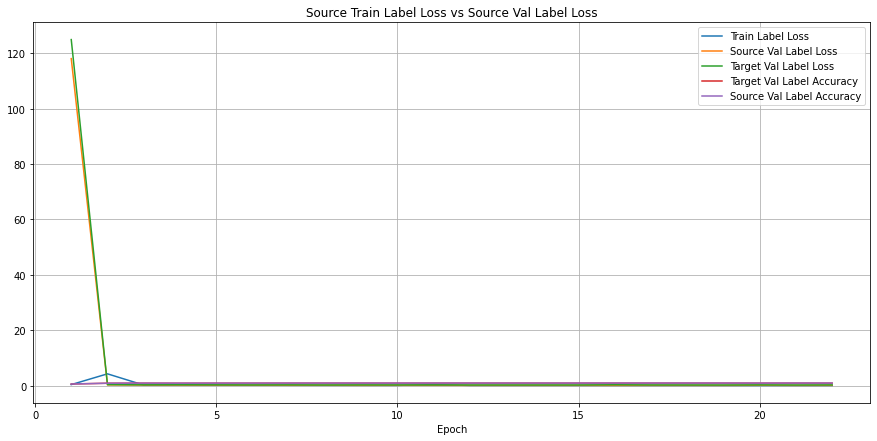

In [25]:
ax = get_loss_curve(experiment)
plt.show()

<AxesSubplot:title={'center':'Results'}>

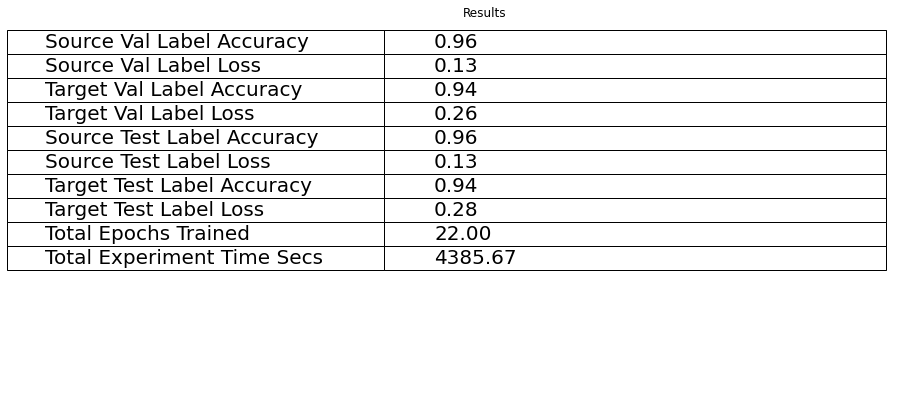

In [26]:
get_results_table(experiment)

<AxesSubplot:title={'center':'Per Domain Validation Accuracy'}, xlabel='domain'>

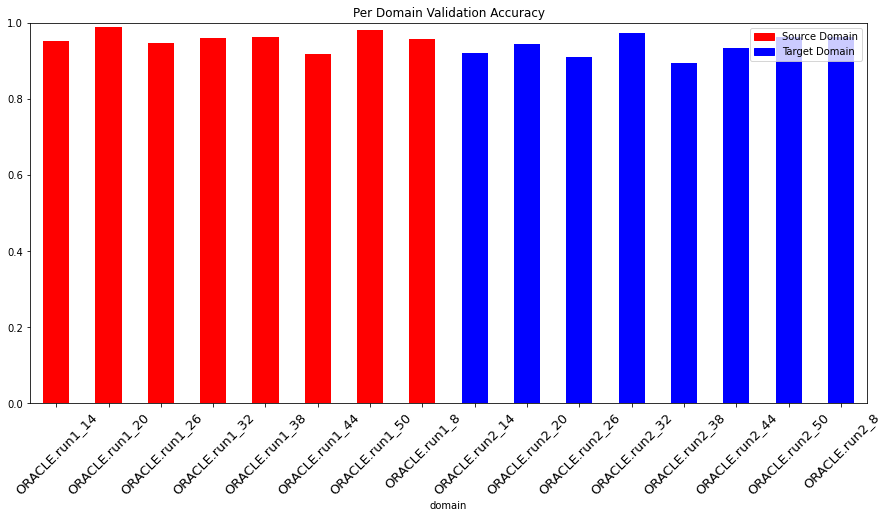

In [27]:
get_domain_accuracies(experiment)

In [28]:
print("Source Test Label Accuracy:", experiment["results"]["source_test_label_accuracy"], "Target Test Label Accuracy:", experiment["results"]["target_test_label_accuracy"])
print("Source Val Label Accuracy:", experiment["results"]["source_val_label_accuracy"], "Target Val Label Accuracy:", experiment["results"]["target_val_label_accuracy"])

Source Test Label Accuracy: 0.9580729166666667 Target Test Label Accuracy: 0.93701171875
Source Val Label Accuracy: 0.95810546875 Target Val Label Accuracy: 0.9380533854166667


In [29]:
json.dumps(experiment)

'{"experiment_name": "tl_1v2:oracle.run1.framed-oracle.run2.framed", "parameters": {"experiment_name": "tl_1v2:oracle.run1.framed-oracle.run2.framed", "device": "cuda", "lr": 0.0001, "n_shot": 3, "n_query": 2, "train_k_factor": 3, "val_k_factor": 2, "test_k_factor": 2, "torch_default_dtype": "torch.float32", "n_epoch": 50, "patience": 3, "criteria_for_best": "target_accuracy", "x_net": [{"class": "nnReshape", "kargs": {"shape": [-1, 1, 2, 256]}}, {"class": "Conv2d", "kargs": {"in_channels": 1, "out_channels": 256, "kernel_size": [1, 7], "bias": false, "padding": [0, 3]}}, {"class": "ReLU", "kargs": {"inplace": true}}, {"class": "BatchNorm2d", "kargs": {"num_features": 256}}, {"class": "Conv2d", "kargs": {"in_channels": 256, "out_channels": 80, "kernel_size": [2, 7], "bias": true, "padding": [0, 3]}}, {"class": "ReLU", "kargs": {"inplace": true}}, {"class": "BatchNorm2d", "kargs": {"num_features": 80}}, {"class": "Flatten", "kargs": {}}, {"class": "Linear", "kargs": {"in_features": 2048